In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm
from math import ceil


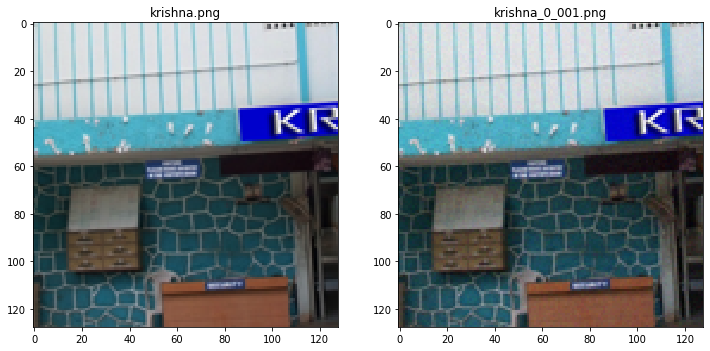

In [15]:
# Read and plot the images
img1 = cv2.imread('krishna.png')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB) # Convert to RGB from BGR
img2 = cv2.imread('krishna_0_001.png')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

f, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].imshow(img1)
axs[0].set_title("krishna.png")
axs[1].imshow(img2)
axs[1].set_title("krishna_0_001.png")
plt.show()

The expression for the NLM filtered image $\hat{f}$ is given by $\hat{f}(\underline{p}) = \sum_{\underline{q}\in G} G_\sigma(N_{\underline{p}}-N_{\underline{q}}) \cdot f(q)$ where $N_{\underline{p}}$ is the patch at $\underline{p}$ and $G_\sigma(\underline{x}) = e^{-\sum_{i=1}^{M} x_i^2/ 2\sigma^2} $.

In [16]:
# Compute the expression when gaussian filter is applied to a vector
def gaussian_filter(X, sigma_nlm):
    assert len(X.shape) <= 2
    return np.exp(-np.sum(X**2)/(2*(sigma_nlm**2)))

# Compute the NLM filtered image f_hat for a noisy image g and parameters W, Wsim, sigma_nlm
def NLM_filter(g, Wsim, W, sigma_nlm):
    # Pad the image so that output size is same as input size
    pad_l = Wsim + W
    g_new = np.pad(g,((pad_l, pad_l),(pad_l, pad_l),(0,0)),'constant', constant_values = 0)

    (l,b) = g_new.shape[:2]

    filtered_image = np.zeros(g.shape)

    # We deal with each channel among R,G,B independently.
    for channel in range(g.shape[-1]):
        for x in range(pad_l, l-pad_l):
            for y in range(pad_l, b-pad_l):
                # x and y are the coordinates of the image. For each pixel, we check its neighbourhood
                # and assign weights such that pixels with simlar intensities have higher weightage
                Z = 0.
                gp = 0.
                Np = g_new[x-Wsim:x+Wsim+1, y-Wsim:y+Wsim+1,channel]

                for i in range(x-W,x+W+1):
                    for j in range(y-W,y+W+1):
                        Nq = g_new[i-Wsim:i+Wsim+1, j-Wsim:j+Wsim+1, channel]
                        gaussian_weight = gaussian_filter(Np-Nq, sigma_nlm)
                        gp+=(gaussian_weight*g_new[i,j,channel])
                        Z+=gaussian_weight
                
                # The denoised intensity is the weighted sum of the pixel intensities
                # Weights are normalised so that their sum is 1.
                filtered_image[x-pad_l,y-pad_l, channel] = gp/Z
    
    return filtered_image

# PSNR function
def PSNR(f,f_hat, mx = 255.0):
    mse = np.mean((f-f_hat)**2)
    return 10*np.log10(mx*mx/mse)



We now compute the filtered images the PSNR values for the given parameters. The image intensity was normalised to 1.0 by dividing by 255 since the gaussian filter function overflows when the maximum pixel intensity was 255.


In [17]:
W1 = 3
W_sim1 = 3
W2 = 5
W_sim2 = 3

psnr_values1= []
filtered_images1 = []
psnr_values2= []
filtered_images2 = []

for sig_nlm in tqdm(np.arange(0.1,0.6,0.1)):
    # Compute and store the filtered images and corresponding PSNR values
    filtered_image1 = NLM_filter(g = img2/255.0, Wsim= W_sim1, W=W1, sigma_nlm=sig_nlm)
    filtered_images1.append(filtered_image1)
    filtered_image2 = NLM_filter(g = img2/255.0, Wsim= W_sim2, W=W2, sigma_nlm=sig_nlm)
    filtered_images2.append(filtered_image2)
    
    psnr_values1.append(PSNR(img1/255.0, filtered_image1, mx=1.0))
    psnr_values2.append(PSNR(img1/255.0, filtered_image2, mx=1.0))



100%|██████████| 5/5 [06:47<00:00, 81.49s/it]


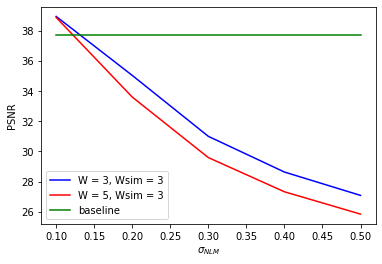

In [18]:
# Compute the baseline - PSNR between the original and noisy image
baseline_psnr = PSNR(img1/255.0, img2/255.0, mx = 1.0)
# Plot PSNR vs sigma_nlm for both settings and show the baseline
plt.plot(np.arange(0.1,0.6,0.1), psnr_values1, 'b', label = f"W = {W1}, Wsim = {W_sim1}")
plt.plot(np.arange(0.1,0.6,0.1), psnr_values2, 'r', label = f"W = {W2}, Wsim = {W_sim2}")
plt.plot(np.arange(0.1,0.6,0.1), np.full(5, baseline_psnr), 'g', label = f"baseline")
plt.ylabel("PSNR")
plt.xlabel(u"$\sigma_{NLM}$")
plt.legend()
plt.show()

Using PSNR as the metric, we see that the NLM filter produces better images for $\sigma_{NLM}=0.1$ but produces worse images for the higher values of $\sigma_{NLM}$.

# Q2

In [19]:
# Compute the expression when gaussian filter is applied to a vector
def gaussian_filter2(X, sigma_g):
    assert len(X.shape) == 1
    return np.exp(-np.sum(X**2)/(2*(sigma_g**2)))
    
# Compute the gaussian filtered image f_hat for a noisy image g and parameters sigma_g and kernel_size
def gaussian_filtering(g, sigma_g, kernel_size = 7):
    # Pad the image so that output size is same as input size
    W = kernel_size//2
    g_new = np.pad(g,((W, W),(W, W),(0,0)),'constant', constant_values = 0)

    (l,b) = g_new.shape[:2]

    filtered_image = np.zeros(g.shape)

    # We deal with each channel among R,G,B independently.
    for channel in range(g.shape[-1]):
        for x in range(W, l-W):
            for y in range(W, b-W):
                Z = 0.
                gp = 0.
                # Same as NLM filter except that p and q are used instad of Np and Nq as shown below.
                p_vec = np.array([x, y])

                for i in range(x-W,x+W+1):
                    for j in range(y-W,y+W+1):
                        q_vec = np.array([i, j])
                        gaussian_weight = gaussian_filter2(p_vec-q_vec, sigma_g)
                        gp+=(gaussian_weight*g_new[i,j,channel])
                        Z+=gaussian_weight
                
                # The denoised intensity is the weighted sum of the pixel intensities
                # Weights are normalised so that their sum is 1.
                filtered_image[x-W,y-W, channel] = gp/Z
    
    return filtered_image

In [20]:
psnr_values_g= []
filtered_images_g = []

for sig_g in tqdm(np.arange(0.1,0.6,0.1)):
    filtered_image_g = gaussian_filtering(g = img2/255.0, sigma_g= sig_g)
    filtered_images_g.append(filtered_image1)

    psnr_values_g.append(PSNR(img1/255.0, filtered_image_g, mx=1.0))


100%|██████████| 5/5 [02:17<00:00, 27.50s/it]


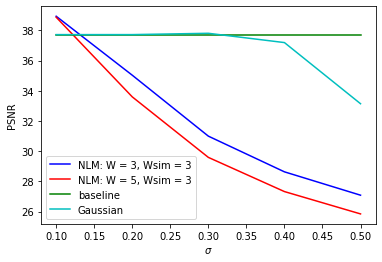

In [38]:
# Show variation of gaussian psnr values with sigma_g in the same plot
plt.plot(np.arange(0.1,0.6,0.1), psnr_values1, 'b', label = f"NLM: W = {W1}, Wsim = {W_sim1}")
plt.plot(np.arange(0.1,0.6,0.1), psnr_values2, 'r', label = f"NLM: W = {W2}, Wsim = {W_sim2}")
plt.plot(np.arange(0.1,0.6,0.1), np.full(5, baseline_psnr), 'g', label = f"baseline")
plt.plot(np.arange(0.1,0.6,0.1), psnr_values_g, 'c', label = f"Gaussian")
plt.ylabel("PSNR")
plt.xlabel(u"$\sigma$")
plt.legend()
plt.show()

Here we find that for the lower values of $\sigma_g$, there is not much change between the gaussian PSNR and baseline, but as $\sigma_g$ increases, gaussian filtering produces results with slightly lower PSNR.

# Q3

In [22]:
# Just copied the code from above but added x,y as parameter so that we can get the kernel corresponding to each pixel.
def get_nlm_kernel(g, W, W_sim, sig_nlm, x, y):
    nlm_filter = np.zeros((2*W+1, 2*W+1, 3))
    pad_l = W+W_sim
    g_new = np.pad(g,((pad_l, pad_l),(pad_l, pad_l),(0,0)),'constant', constant_values = 0)
    xd = x+pad_l
    yd = y+pad_l
    
    for channel in range(3):
        gp = 0.
        Z = 0.
        Np = g_new[xd-W_sim:xd+W_sim+1, yd-W_sim:yd+W_sim+1,channel]

        for i in range(xd-W,xd+W+1):
            for j in range(yd-W,yd+W+1):
                Nq = g_new[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1, channel]
                gaussian_weight = gaussian_filter(Np-Nq, sig_nlm)
                nlm_filter[i-(xd-W), j-(yd-W), channel] = gaussian_weight
        
        # Normalise kernel for each channel
        nlm_filter[:,:,channel] = nlm_filter[:,:,channel]/np.sum(nlm_filter[:,:,channel])
        
    return nlm_filter

def get_gauss_kernel(sig_g, x, y, kernel_size = 11):
    W = kernel_size//2
    gauss_filter = np.zeros((kernel_size, kernel_size, 3))
    xd = x+W
    yd = y+W
    
    for channel in range(3):
        gp = 0.
        Z = 0.
        p_vec = np.array([xd, yd])

        for i in range(xd-W,xd+W+1):
            for j in range(yd-W,yd+W+1):
                q_vec = np.array([i, j])
                gaussian_weight = gaussian_filter2(p_vec-q_vec, sig_g)
                gauss_filter[i-(xd-W), j-(yd-W), channel] = gaussian_weight

        # Normalise kernel for each channel
        gauss_filter[:,:,channel] = gauss_filter[:,:,channel]/np.sum(gauss_filter[:,:,channel])

    return gauss_filter

In [23]:
# For the given coordinates, compute the NLM and gaussian filters
x1 = 31
y1 = 46
x2 = 38
y2 = 58

W = 5
W_sim = 3
sig_nlm = 0.5
sigma_g = 1.0

nlm_filter1 = get_nlm_kernel(img2/255.0, W, W_sim, sig_nlm, x1, y1)
nlm_filter2 = get_nlm_kernel(img2/255.0, W, W_sim, sig_nlm, x2, y2)
g_filter1 = get_gauss_kernel(sigma_g, x1, y1, kernel_size = 11)
g_filter2 = get_gauss_kernel(sigma_g, x2, y2, kernel_size = 11)




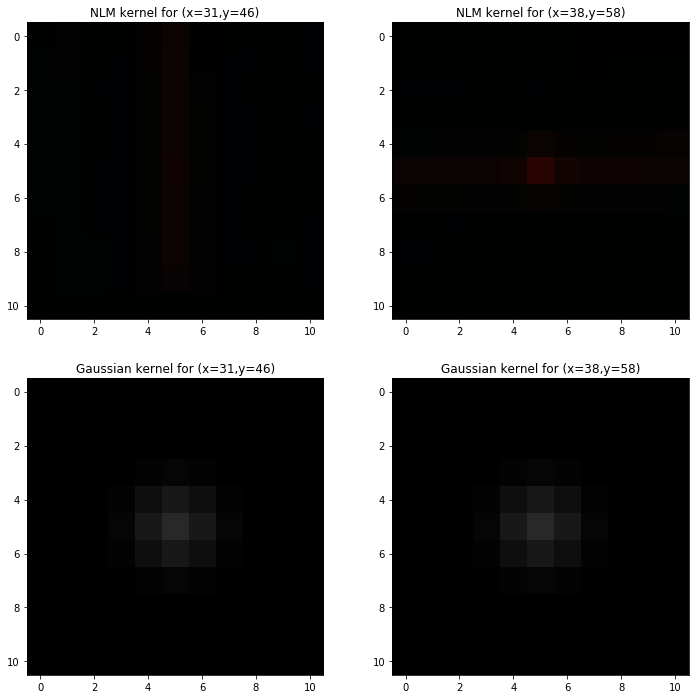

In [39]:
# Plot the obtained gaussian and NLM filters
fig, axs = plt.subplots(2, 2, figsize = (12,12))
axs[0,0].imshow(nlm_filter1)
axs[0,0].set_title(f"NLM kernel for (x={x1},y={y1})")
axs[0,1].imshow(nlm_filter2)
axs[0,1].set_title(f"NLM kernel for (x={x2},y={y2})")
axs[1,0].imshow(g_filter1)
axs[1,0].set_title(f"Gaussian kernel for (x={x1},y={y1})")
axs[1,1].imshow(g_filter2)
axs[1,1].set_title(f"Gaussian kernel for (x={x2},y={y2})")
plt.show()

The NLM kernel are different while the gaussian kernels are the same for both the coordinates. THis is expected since NLM kernel is dependent on the pixel intensity of the coordinate and its neighbourhood. This is not the case for the Gaussian kernel.

We also notice that for gaussian kernel all three channels have equal weights. Hence the kernel appears to be in grayscale.

Note: First image is not black. THere is a faint red line in the centre.

# Q4

In [25]:
# For the given coordinates, extract the noisy and denoised patches of size 11x11
noisy_patch1 = (img2/255.0)[x1-5:x1+6, y1-5:y1+6, :]
nlm_denoised_patch1 = filtered_images2[-1][x1-5:x1+6, y1-5:y1+6, :]
gauss_denoised_patch1 = filtered_images_g[-1][x1-5:x1+6, y1-5:y1+6, :]

noisy_patch2 = (img2/255.0)[x2-5:x2+6, y2-5:y2+6, :]
nlm_denoised_patch2 = filtered_images2[-1][x2-5:x2+6, y2-5:y2+6, :]
gauss_denoised_patch2 = filtered_images_g[-1][x2-5:x2+6, y2-5:y2+6, :]


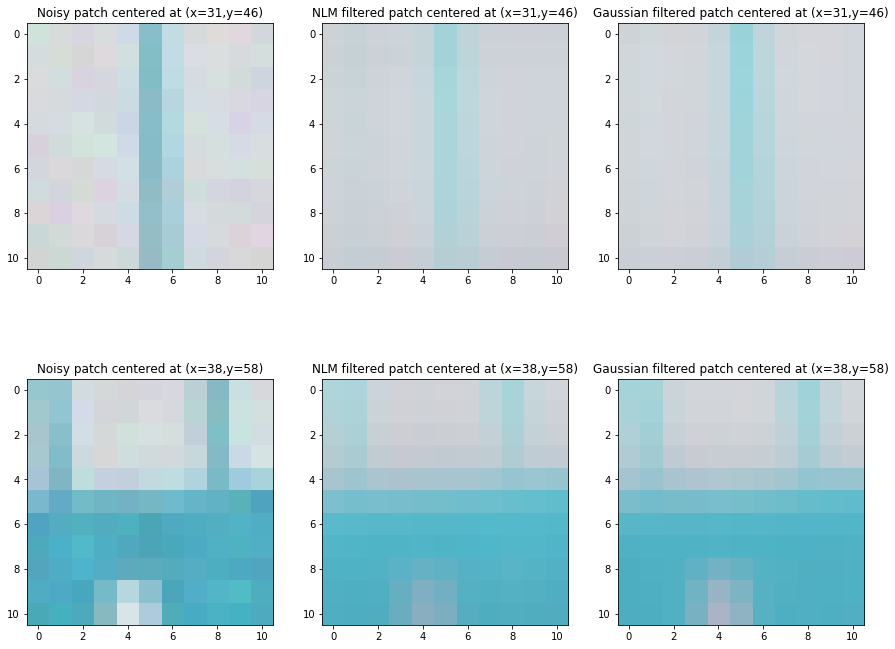

In [26]:
# Plot the noisy and denoised image patches for both coordinates
fig, axs = plt.subplots(2, 3, figsize = (15,12))
axs[0,0].imshow(noisy_patch1)
axs[0,0].set_title(f"Noisy patch centered at (x={x1},y={y1})")
axs[0,1].imshow(nlm_denoised_patch1)
axs[0,1].set_title(f"NLM filtered patch centered at (x={x1},y={y1})")
axs[0,2].imshow(gauss_denoised_patch1)
axs[0,2].set_title(f"Gaussian filtered patch centered at (x={x1},y={y1})")
axs[1,0].imshow(noisy_patch2)
axs[1,0].set_title(f"Noisy patch centered at (x={x2},y={y2})")
axs[1,1].imshow(nlm_denoised_patch2)
axs[1,1].set_title(f"NLM filtered patch centered at (x={x2},y={y2})")
axs[1,2].imshow(gauss_denoised_patch2)
axs[1,2].set_title(f"Gaussian filtered patch centered at (x={x2},y={y2})")
plt.show()

We can clearly see that the images are lot smoother after both NLM and Gaussian filtering. 